# Market Timing Analysis - 4-Level Regime System

Analyze market regimes using BTC, ETH, and LTC:
- **Harsh Bull**: All 3 coins above EMA50
- **Bull**: 2 of 3 coins above EMA50
- **Bear**: 2 of 3 coins below EMA50
- **Harsh Bear**: All 3 coins below EMA50

This analysis will guide strategy design for each regime.

## 1. Setup & Data Loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import logging

logging.basicConfig(level=logging.INFO)

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("✓ Imports complete")

✓ Imports complete


In [3]:
from CoinTrading.data import DataLoader
from CoinTrading.indicators import EMA

# Load data for BTC, ETH, LTC
symbols = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT']

loader = DataLoader()
raw_data = loader.load_multiple(symbols, skip_errors=True)

data = {}

for symbol in symbols:
    if symbol not in raw_data:
        print(f"Warning: {symbol} not loaded")
        continue
        
    df = raw_data[symbol].copy()
    
    # Calculate EMA50
    ema = EMA(period=50)
    df = ema.calculate(df)
    
    # Drop NaN rows
    df = df.dropna()
    
    data[symbol] = df
    print(f"{symbol}: {len(df)} days from {df.index[0].date()} to {df.index[-1].date()}")

print(f"\n✓ Loaded {len(data)} symbols")

INFO:CoinTrading.data.binance_client:Initialized BinanceClient for futures market
INFO:CoinTrading.data.data_loader:DataLoader initialized with cache: .cache/ohlcv
INFO:CoinTrading.data.data_loader:Successfully loaded 3/3 symbols


BTCUSDT: 480 days from 2024-06-13 to 2025-10-05
ETHUSDT: 480 days from 2024-06-13 to 2025-10-05
LTCUSDT: 480 days from 2024-06-13 to 2025-10-05

✓ Loaded 3 symbols


## 2. Regime Detection

For each date, check **yesterday's close vs yesterday's EMA50** for all 3 coins.

In [4]:
# Get common date range (intersection of all symbols)
common_dates = data['BTCUSDT'].index
for symbol in symbols:
    common_dates = common_dates.intersection(data[symbol].index)

common_dates = sorted(common_dates)
print(f"Common date range: {common_dates[0].date()} to {common_dates[-1].date()} ({len(common_dates)} days)")

# Detect regime for each date
regimes = []
regime_details = []

for i, date in enumerate(common_dates):
    if i == 0:
        # First date: no yesterday, skip
        regimes.append('unknown')
        regime_details.append({'date': date, 'regime': 'unknown', 'above_ema': 0})
        continue
    
    yesterday = common_dates[i - 1]
    
    # Count how many coins were above EMA50 yesterday
    above_count = 0
    positions = {}
    
    for symbol in symbols:
        df = data[symbol]
        
        if yesterday in df.index:
            close_yesterday = df.loc[yesterday, 'close']
            ema50_yesterday = df.loc[yesterday, 'ema50']
            
            is_above = close_yesterday > ema50_yesterday
            positions[symbol] = 'above' if is_above else 'below'
            
            if is_above:
                above_count += 1
    
    # Classify regime
    if above_count == 3:
        regime = 'harsh_bull'
    elif above_count == 2:
        regime = 'bull'
    elif above_count == 1:
        regime = 'bear'
    else:  # 0
        regime = 'harsh_bear'
    
    regimes.append(regime)
    regime_details.append({
        'date': date,
        'regime': regime,
        'above_ema': above_count,
        **positions
    })

# Create DataFrame
regime_df = pd.DataFrame(regime_details)
regime_df.set_index('date', inplace=True)

print("\n✓ Regime detection complete")
print("\nFirst 10 days:")
print(regime_df.head(10))

Common date range: 2024-06-13 to 2025-10-05 (480 days)

✓ Regime detection complete

First 10 days:
                regime  above_ema BTCUSDT ETHUSDT LTCUSDT
date                                                     
2024-06-13     unknown          0     NaN     NaN     NaN
2024-06-14  harsh_bear          0   below   below   below
2024-06-15  harsh_bear          0   below   below   below
2024-06-16  harsh_bear          0   below   below   below
2024-06-17  harsh_bear          0   below   below   below
2024-06-18  harsh_bear          0   below   below   below
2024-06-19  harsh_bear          0   below   below   below
2024-06-20  harsh_bear          0   below   below   below
2024-06-21  harsh_bear          0   below   below   below
2024-06-22  harsh_bear          0   below   below   below


## 3. Regime Statistics

In [5]:
# Count regime distribution
regime_counts = regime_df['regime'].value_counts()
total_days = len(regime_df) - 1  # Exclude first 'unknown' day

print("Market Regime Distribution:")
print("="*60)
print(f"{'Regime':<15} {'Days':>8} {'Percent':>10} {'Description'}")
print("-"*60)

regime_labels = {
    'harsh_bull': 'All 3 above EMA50',
    'bull': '2 of 3 above EMA50',
    'bear': '1 of 3 above EMA50',
    'harsh_bear': 'All 3 below EMA50'
}

for regime_name in ['harsh_bull', 'bull', 'bear', 'harsh_bear']:
    count = regime_counts.get(regime_name, 0)
    pct = (count / total_days * 100) if total_days > 0 else 0
    print(f"{regime_name:<15} {count:>8} {pct:>9.1f}%  {regime_labels[regime_name]}")

print("="*60)

Market Regime Distribution:
Regime              Days    Percent Description
------------------------------------------------------------
harsh_bull           157      32.8%  All 3 above EMA50
bull                  94      19.6%  2 of 3 above EMA50
bear                  82      17.1%  1 of 3 above EMA50
harsh_bear           146      30.5%  All 3 below EMA50


## 4. Visualization - 3-Panel Price Charts

Show each coin's price and EMA50 with regime-colored backgrounds.

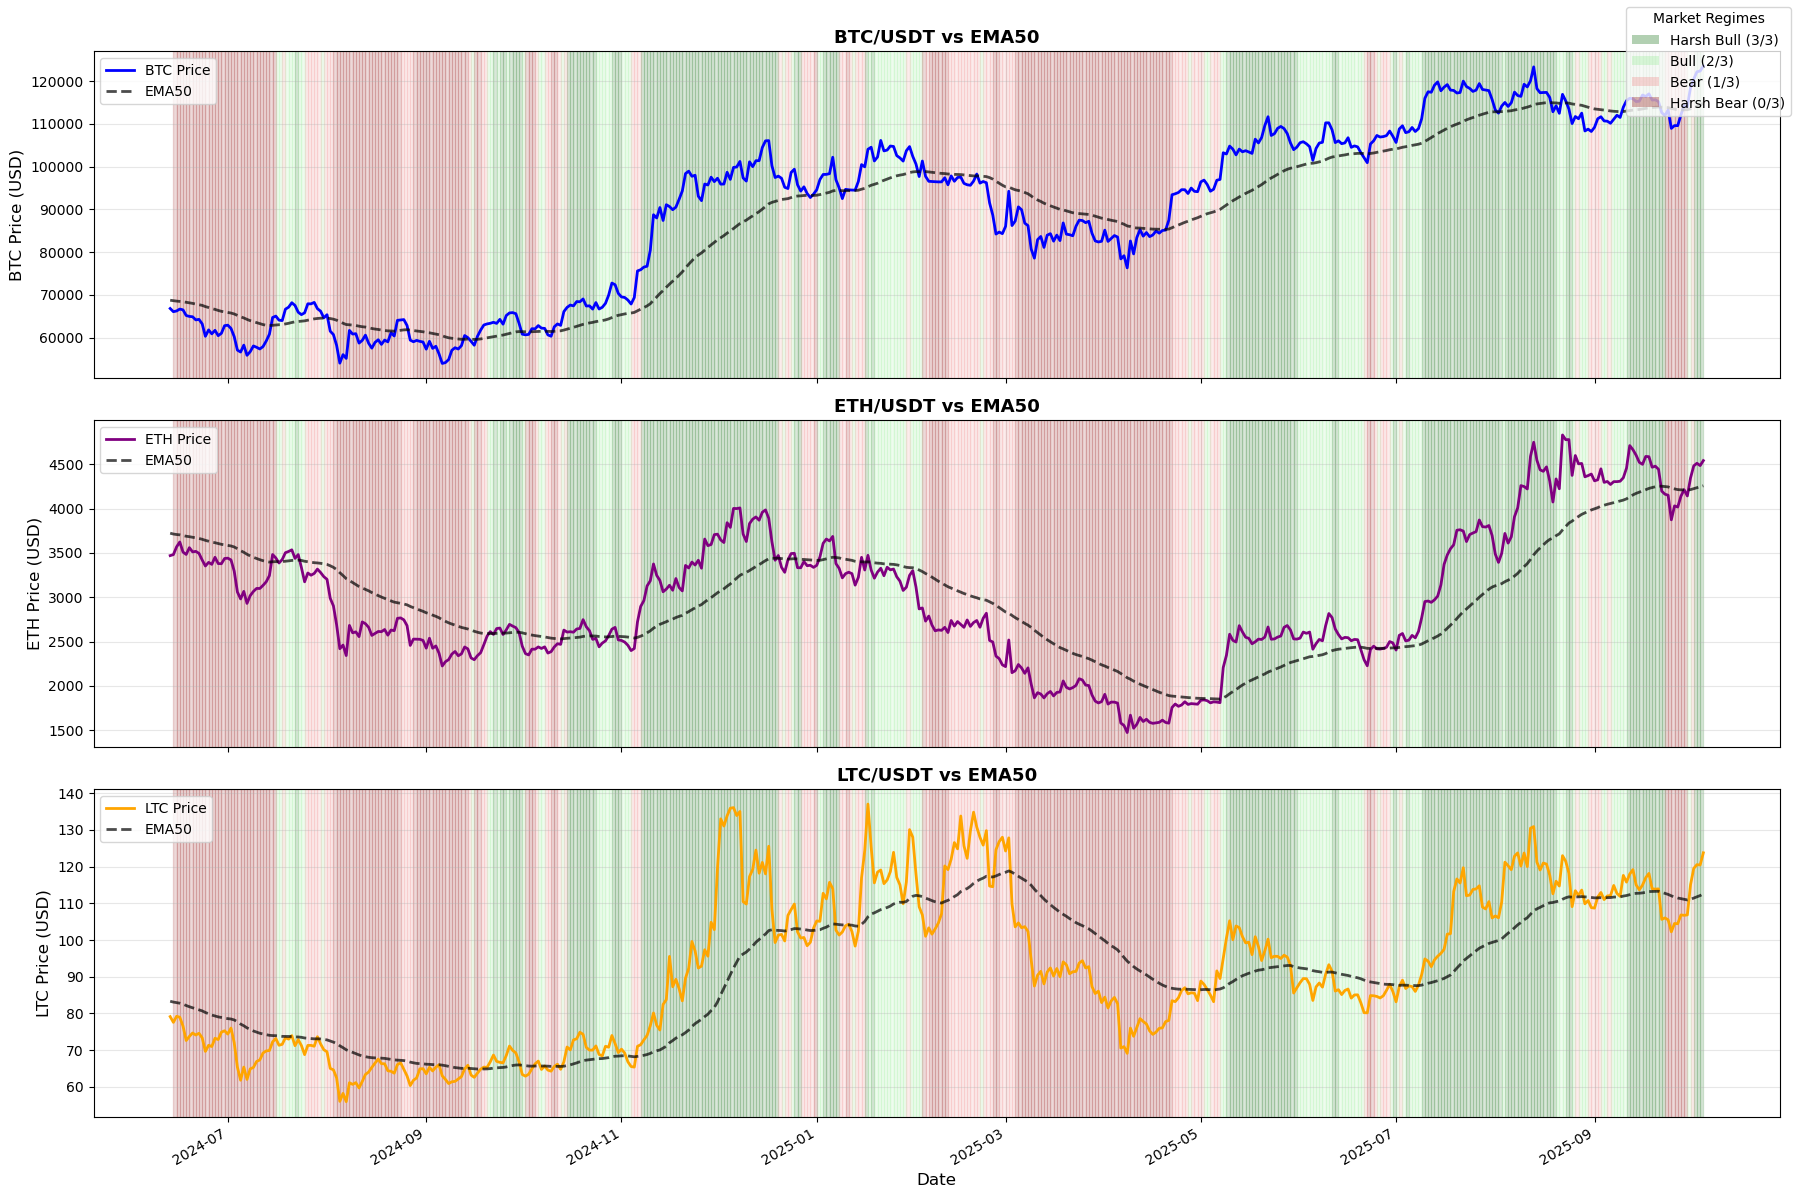


✓ Visualization complete


In [6]:
# Create 3-panel plot
fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

# Color mapping for regimes
regime_colors = {
    'harsh_bull': 'darkgreen',
    'bull': 'lightgreen',
    'bear': 'lightcoral',
    'harsh_bear': 'darkred',
    'unknown': 'white'
}

symbol_names = {'BTCUSDT': 'BTC', 'ETHUSDT': 'ETH', 'LTCUSDT': 'LTC'}
symbol_colors = {'BTCUSDT': 'blue', 'ETHUSDT': 'purple', 'LTCUSDT': 'orange'}

for idx, symbol in enumerate(symbols):
    ax = axes[idx]
    df = data[symbol]
    
    # Plot regime backgrounds
    for i in range(len(common_dates) - 1):
        date = common_dates[i]
        next_date = common_dates[i + 1]
        
        if date in regime_df.index:
            regime = regime_df.loc[date, 'regime']
            color = regime_colors.get(regime, 'white')
            ax.axvspan(date, next_date, alpha=0.15, color=color)
    
    # Plot price and EMA
    ax.plot(df.index, df['close'], label=f'{symbol_names[symbol]} Price', 
            linewidth=2, color=symbol_colors[symbol])
    ax.plot(df.index, df['ema50'], label='EMA50', 
            linewidth=2, color='black', linestyle='--', alpha=0.7)
    
    # Formatting
    ax.set_ylabel(f'{symbol_names[symbol]} Price (USD)', fontsize=12)
    ax.set_title(f'{symbol_names[symbol]}/USDT vs EMA50', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

# Format x-axis
axes[2].set_xlabel('Date', fontsize=12)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Add legend for regimes
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkgreen', alpha=0.3, label='Harsh Bull (3/3)'),
    Patch(facecolor='lightgreen', alpha=0.3, label='Bull (2/3)'),
    Patch(facecolor='lightcoral', alpha=0.3, label='Bear (1/3)'),
    Patch(facecolor='darkred', alpha=0.3, label='Harsh Bear (0/3)')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=10, title='Market Regimes')

plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

print("\n✓ Visualization complete")

## 5. Price Performance by Regime

Calculate average daily returns for each coin in each regime.

In [7]:
# Calculate returns for each symbol
performance_data = []

for symbol in symbols:
    df = data[symbol].copy()
    df['return'] = df['close'].pct_change()
    
    # Merge with regime data
    df = df.join(regime_df[['regime']], how='inner')
    
    # Calculate stats for each regime
    for regime_name in ['harsh_bull', 'bull', 'bear', 'harsh_bear']:
        regime_returns = df[df['regime'] == regime_name]['return']
        
        if len(regime_returns) > 0:
            performance_data.append({
                'symbol': symbol_names[symbol],
                'regime': regime_name,
                'avg_return': regime_returns.mean() * 100,  # Convert to %
                'std_return': regime_returns.std() * 100,
                'days': len(regime_returns),
                'win_rate': (regime_returns > 0).sum() / len(regime_returns) * 100
            })

perf_df = pd.DataFrame(performance_data)

# Display results
print("\nAverage Daily Returns by Regime (%)")
print("="*80)
print(f"{'Regime':<15} {'Symbol':>8} {'Avg Return':>12} {'Volatility':>12} {'Win Rate':>10} {'Days':>8}")
print("-"*80)

for regime_name in ['harsh_bull', 'bull', 'bear', 'harsh_bear']:
    regime_data = perf_df[perf_df['regime'] == regime_name]
    
    if not regime_data.empty:
        print(f"\n{regime_name.upper()}:")
        for _, row in regime_data.iterrows():
            print(f"{'':15} {row['symbol']:>8} {row['avg_return']:>11.2f}% {row['std_return']:>11.2f}% "
                  f"{row['win_rate']:>9.1f}% {row['days']:>8.0f}")

print("="*80)


Average Daily Returns by Regime (%)
Regime            Symbol   Avg Return   Volatility   Win Rate     Days
--------------------------------------------------------------------------------

HARSH_BULL:
                     BTC        0.12%        2.06%      52.2%      157
                     ETH        0.30%        3.50%      51.0%      157
                     LTC        0.18%        4.69%      51.0%      157

BULL:
                     BTC        0.15%        1.89%      53.2%       94
                     ETH        0.17%        3.93%      51.1%       94
                     LTC       -0.09%        3.40%      48.9%       94

BEAR:
                     BTC        0.26%        2.69%      52.4%       82
                     ETH        0.33%        4.17%      56.1%       82
                     LTC        0.59%        4.22%      56.1%       82

HARSH_BEAR:
                     BTC        0.13%        2.79%      50.0%      146
                     ETH       -0.21%        3.70%      47.9%

## 6. Cumulative Returns by Regime

Visualize how each regime contributes to overall returns over time.

In [ ]:
# Calculate cumulative returns for each coin by regime
fig, axes = plt.subplots(3, 1, figsize=(18, 14), sharex=True)

for idx, symbol in enumerate(symbols):
    ax = axes[idx]
    df = data[symbol].copy()
    df['return'] = df['close'].pct_change()
    
    # Merge with regime data
    df = df.join(regime_df[['regime']], how='inner')
    
    # Calculate cumulative returns by regime
    df['cum_return'] = (1 + df['return']).cumprod() - 1
    
    # Plot overall cumulative return
    ax.plot(df.index, df['cum_return'] * 100, 
            linewidth=2.5, color=symbol_colors[symbol], label=f'{symbol_names[symbol]} Overall', alpha=0.9)
    
    # Color regime backgrounds
    for i in range(len(common_dates) - 1):
        date = common_dates[i]
        next_date = common_dates[i + 1]
        
        if date in regime_df.index:
            regime = regime_df.loc[date, 'regime']
            color = regime_colors.get(regime, 'white')
            ax.axvspan(date, next_date, alpha=0.15, color=color)
    
    # Calculate regime-specific cumulative returns
    for regime_name, color in [('harsh_bull', 'darkgreen'), ('bull', 'lightgreen'), 
                                ('bear', 'lightcoral'), ('harsh_bear', 'darkred')]:
        regime_mask = df['regime'] == regime_name
        if regime_mask.any():
            # Cumulative return only during this regime
            regime_returns = df[regime_mask]['return']
            regime_cum = (1 + regime_returns).cumprod() - 1
            
            ax.scatter(regime_returns.index, regime_cum * 100, 
                      alpha=0.3, s=10, color=color, label=f'{regime_name.replace("_", " ").title()}')
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.set_ylabel(f'{symbol_names[symbol]} Return (%)', fontsize=12)
    ax.set_title(f'{symbol_names[symbol]} Cumulative Returns by Regime', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3)

axes[2].set_xlabel('Date', fontsize=12)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

print("\n✓ Cumulative returns by regime plotted")

# Calculate regime contribution to total returns
print("\n" + "="*80)
print("Regime Contribution to Total Returns")
print("="*80)
print(f"{'Symbol':<10} {'Regime':<15} {'Days':>8} {'Cum Return':>12} {'Contribution':>14}")
print("-"*80)

for symbol in symbols:
    df = data[symbol].copy()
    df['return'] = df['close'].pct_change()
    df = df.join(regime_df[['regime']], how='inner')
    
    total_return = ((1 + df['return']).prod() - 1) * 100
    
    print(f"\n{symbol_names[symbol]}:")
    for regime_name in ['harsh_bull', 'bull', 'bear', 'harsh_bear']:
        regime_mask = df['regime'] == regime_name
        if regime_mask.any():
            regime_returns = df[regime_mask]['return']
            regime_cum_return = ((1 + regime_returns).prod() - 1) * 100
            days = len(regime_returns)
            contribution = regime_cum_return / total_return * 100 if total_return != 0 else 0
            
            print(f"{'':10} {regime_name:<15} {days:>8} {regime_cum_return:>11.1f}% {contribution:>13.1f}%")
    
    print(f"{'':10} {'TOTAL':<15} {len(df):>8} {total_return:>11.1f}% {'100.0%':>14}")

print("="*80)

## 6. Regime Transitions

Analyze which regimes follow which (transition matrix).

## 7. Position Direction Analysis

Analyze returns when each coin is above EMA50 (would be long) vs below (would be short).

In [ ]:
# Analyze returns by position direction
print("Position Direction Performance Analysis")
print("="*80)
print("(Position based on yesterday's close vs yesterday's EMA50)")
print("="*80)
print(f"{'Symbol':<10} {'Position':<12} {'Days':>8} {'Avg Return':>12} {'Volatility':>12} {'Win Rate':>10} {'Cum Return':>12}")
print("-"*80)

direction_analysis = []

for symbol in symbols:
    df = data[symbol].copy()
    df['return'] = df['close'].pct_change()
    
    # Determine position based on yesterday's data
    df['prev_close'] = df['close'].shift(1)
    df['prev_ema50'] = df['ema50'].shift(1)
    df['position'] = df.apply(
        lambda row: 'long' if row['prev_close'] > row['prev_ema50'] else 'short', 
        axis=1
    )
    
    # Drop NaN
    df = df.dropna()
    
    print(f"\n{symbol_names[symbol]}:")
    
    for position in ['long', 'short']:
        pos_mask = df['position'] == position
        if pos_mask.any():
            pos_returns = df[pos_mask]['return']
            days = len(pos_returns)
            avg_return = pos_returns.mean() * 100
            volatility = pos_returns.std() * 100
            win_rate = (pos_returns > 0).sum() / len(pos_returns) * 100
            cum_return = ((1 + pos_returns).prod() - 1) * 100
            
            # For short positions, we want negative returns (price going down)
            # So calculate P&L as -1 * return
            if position == 'short':
                pnl_returns = -pos_returns
                pnl_avg = pnl_returns.mean() * 100
                pnl_cum = ((1 + pnl_returns).prod() - 1) * 100
            else:
                pnl_avg = avg_return
                pnl_cum = cum_return
            
            print(f"{'':10} {position:<12} {days:>8} {avg_return:>11.2f}% {volatility:>11.2f}% {win_rate:>9.1f}% {cum_return:>11.1f}%")
            print(f"{'':10} {'  -> P&L':<12} {'':>8} {pnl_avg:>11.2f}% {'':>12} {'':>10} {pnl_cum:>11.1f}%")
            
            direction_analysis.append({
                'symbol': symbol_names[symbol],
                'position': position,
                'days': days,
                'avg_return': avg_return,
                'pnl_avg': pnl_avg,
                'volatility': volatility,
                'win_rate': win_rate,
                'cum_return': cum_return,
                'pnl_cum': pnl_cum
            })

print("="*80)
print("\nKey Insight:")
print("- 'Avg Return' = Average price change")
print("- 'P&L' = Strategy P&L (long positions want positive returns, short want negative returns)")
print("- Positive P&L Cum Return = This position direction would make money")

# Summary visualization
dir_df = pd.DataFrame(direction_analysis)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Average P&L by position and coin
ax1 = axes[0]
positions_order = ['long', 'short']
x = np.arange(len(symbols))
width = 0.35

for i, position in enumerate(positions_order):
    pos_data = dir_df[dir_df['position'] == position].set_index('symbol')
    values = [pos_data.loc[symbol_names[s], 'pnl_avg'] if symbol_names[s] in pos_data.index else 0 
              for s in symbols]
    offset = width * (i - 0.5)
    ax1.bar(x + offset, values, width, label=position.capitalize(), 
            color='green' if position == 'long' else 'red', alpha=0.7)

ax1.set_ylabel('Average Daily P&L (%)', fontsize=12)
ax1.set_title('Average Daily P&L by Position Direction', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([symbol_names[s] for s in symbols])
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Cumulative P&L by position and coin
ax2 = axes[1]
for i, position in enumerate(positions_order):
    pos_data = dir_df[dir_df['position'] == position].set_index('symbol')
    values = [pos_data.loc[symbol_names[s], 'pnl_cum'] if symbol_names[s] in pos_data.index else 0 
              for s in symbols]
    offset = width * (i - 0.5)
    ax2.bar(x + offset, values, width, label=position.capitalize(), 
            color='green' if position == 'long' else 'red', alpha=0.7)

ax2.set_ylabel('Cumulative P&L (%)', fontsize=12)
ax2.set_title('Cumulative P&L by Position Direction', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([symbol_names[s] for s in symbols])
ax2.legend()
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Position direction analysis complete")

In [8]:
# Calculate regime transitions
regime_list = regime_df['regime'].tolist()
transitions = {}

for i in range(len(regime_list) - 1):
    current = regime_list[i]
    next_regime = regime_list[i + 1]
    
    if current == 'unknown':
        continue
    
    key = (current, next_regime)
    transitions[key] = transitions.get(key, 0) + 1

# Create transition matrix
regime_order = ['harsh_bull', 'bull', 'bear', 'harsh_bear']
transition_matrix = pd.DataFrame(0, index=regime_order, columns=regime_order)

for (from_regime, to_regime), count in transitions.items():
    if from_regime in regime_order and to_regime in regime_order:
        transition_matrix.loc[from_regime, to_regime] = count

# Convert to percentages
transition_pct = transition_matrix.div(transition_matrix.sum(axis=1), axis=0) * 100

print("\nRegime Transition Matrix (% probability)")
print("="*80)
print("From \\ To        Harsh Bull    Bull      Bear  Harsh Bear")
print("-"*80)

regime_short = {'harsh_bull': 'Harsh Bull', 'bull': 'Bull', 'bear': 'Bear', 'harsh_bear': 'Harsh Bear'}

for from_regime in regime_order:
    row = transition_pct.loc[from_regime]
    print(f"{regime_short[from_regime]:<15} {row['harsh_bull']:>9.1f}% {row['bull']:>9.1f}% "
          f"{row['bear']:>9.1f}% {row['harsh_bear']:>10.1f}%")

print("="*80)
print("\nInterpretation:")
print("- High diagonal values = regimes tend to persist")
print("- High off-diagonal = regimes change quickly")


Regime Transition Matrix (% probability)
From \ To        Harsh Bull    Bull      Bear  Harsh Bear
--------------------------------------------------------------------------------
Harsh Bull           87.8%       9.6%       1.9%        0.6%
Bull                 17.0%      59.6%      20.2%        3.2%
Bear                  4.9%      24.4%      59.8%       11.0%
Harsh Bear            0.0%       2.1%       7.5%       90.4%

Interpretation:
- High diagonal values = regimes tend to persist
- High off-diagonal = regimes change quickly


## 8. Hypothetical Strategy Simulation

Simulate the regime-based strategy to see what it would have returned.

Strategy rules:
- Long each coin if above EMA50 (yesterday), short if below
- Base weight: 1/3 per coin
- Leverage multiplier by regime:
  - Harsh Bull (3/3 above): 1.5x
  - Bull (2/3 above): 1.0x
  - Bear (1/3 above): 0.5x
  - Harsh Bear (0/3 above): 1.5x

In [ ]:
# Simulate the regime-based strategy
regime_leverage = {
    'harsh_bull': 1.5,
    'bull': 1.0,
    'bear': 0.5,
    'harsh_bear': 1.5
}

# Prepare data with returns
strategy_data = {}
for symbol in symbols:
    df = data[symbol].copy()
    df['return'] = df['close'].pct_change()
    df['prev_close'] = df['close'].shift(1)
    df['prev_ema50'] = df['ema50'].shift(1)
    strategy_data[symbol] = df

# Get common dates
common_dates = strategy_data['BTCUSDT'].index
for symbol in symbols:
    common_dates = common_dates.intersection(strategy_data[symbol].index)
common_dates = sorted(common_dates)

# Simulate strategy
portfolio_value = 1.0
portfolio_values = [portfolio_value]
portfolio_dates = [common_dates[0]]
positions_history = []
leverage_history = []

for i in range(1, len(common_dates)):
    date = common_dates[i]
    yesterday = common_dates[i - 1]
    
    # Determine regime (based on yesterday's data)
    above_count = 0
    coin_positions = {}
    
    for symbol in symbols:
        df = strategy_data[symbol]
        if yesterday in df.index:
            close_yesterday = df.loc[yesterday, 'prev_close'] if pd.notna(df.loc[yesterday, 'prev_close']) else df.loc[yesterday, 'close']
            ema50_yesterday = df.loc[yesterday, 'prev_ema50'] if pd.notna(df.loc[yesterday, 'prev_ema50']) else df.loc[yesterday, 'ema50']
            
            if pd.notna(close_yesterday) and pd.notna(ema50_yesterday):
                is_above = close_yesterday > ema50_yesterday
                coin_positions[symbol] = is_above
                if is_above:
                    above_count += 1
    
    # Classify regime
    if above_count == 3:
        regime = 'harsh_bull'
    elif above_count == 2:
        regime = 'bull'
    elif above_count == 1:
        regime = 'bear'
    else:
        regime = 'harsh_bear'
    
    leverage = regime_leverage[regime]
    
    # Calculate portfolio return for this day
    portfolio_return = 0
    position_weights = {}
    
    for symbol in symbols:
        df = strategy_data[symbol]
        if date in df.index and symbol in coin_positions:
            # Position direction: +1 if above EMA (long), -1 if below (short)
            direction = 1 if coin_positions[symbol] else -1
            
            # Base weight
            base_weight = 1.0 / len(symbols)
            
            # Final weight
            weight = direction * base_weight * leverage
            position_weights[symbol] = weight
            
            # Return for this position
            asset_return = df.loc[date, 'return']
            if pd.notna(asset_return):
                portfolio_return += weight * asset_return
    
    # Update portfolio value
    portfolio_value *= (1 + portfolio_return)
    portfolio_values.append(portfolio_value)
    portfolio_dates.append(date)
    
    positions_history.append({
        'date': date,
        'regime': regime,
        'leverage': leverage,
        **position_weights
    })

# Create results DataFrame
strategy_equity = pd.Series(portfolio_values, index=portfolio_dates)
positions_df = pd.DataFrame(positions_history).set_index('date')

# Calculate strategy metrics
strategy_returns = strategy_equity.pct_change().dropna()
total_return = (strategy_equity.iloc[-1] - 1) * 100
days = len(strategy_returns)
years = days / 365
cagr = (strategy_equity.iloc[-1] ** (1/years) - 1) * 100 if years > 0 else 0
cum_max = strategy_equity.expanding().max()
drawdown = (strategy_equity - cum_max) / cum_max * 100
mdd = drawdown.min()
volatility = strategy_returns.std() * np.sqrt(365) * 100
sharpe = (strategy_returns.mean() / strategy_returns.std() * np.sqrt(365)) if strategy_returns.std() > 0 else 0
win_rate = (strategy_returns > 0).sum() / len(strategy_returns) * 100

print("Hypothetical Regime-Based Strategy Performance")
print("="*80)
print(f"Period: {portfolio_dates[0].date()} to {portfolio_dates[-1].date()} ({days} days)")
print(f"Final Portfolio Value: {strategy_equity.iloc[-1]:.4f}")
print(f"Total Return: {total_return:.1f}%")
print(f"CAGR: {cagr:.1f}%")
print(f"Max Drawdown: {mdd:.1f}%")
print(f"Volatility (annualized): {volatility:.1f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Win Rate: {win_rate:.1f}%")
print("="*80)

# Plot equity curve with regime backgrounds
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Plot 1: Equity curve
ax1 = axes[0]

# Color regime backgrounds
for i in range(len(positions_df) - 1):
    date = positions_df.index[i]
    next_date = positions_df.index[i + 1]
    regime = positions_df.loc[date, 'regime']
    color = regime_colors.get(regime, 'white')
    ax1.axvspan(date, next_date, alpha=0.15, color=color)

ax1.plot(strategy_equity.index, strategy_equity.values, linewidth=2, color='darkblue', label='Strategy Equity')
ax1.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8, label='Initial Value')
ax1.set_ylabel('Portfolio Value', fontsize=12)
ax1.set_title('Regime-Based Strategy Equity Curve', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Leverage over time
ax2 = axes[1]

# Color regime backgrounds
for i in range(len(positions_df) - 1):
    date = positions_df.index[i]
    next_date = positions_df.index[i + 1]
    regime = positions_df.loc[date, 'regime']
    color = regime_colors.get(regime, 'white')
    ax2.axvspan(date, next_date, alpha=0.15, color=color)

ax2.plot(positions_df.index, positions_df['leverage'], linewidth=2, color='purple', label='Leverage Multiplier')
ax2.set_ylabel('Leverage', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_title('Leverage Over Time', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 2])

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Add legend for regimes
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkgreen', alpha=0.3, label='Harsh Bull (1.5x)'),
    Patch(facecolor='lightgreen', alpha=0.3, label='Bull (1.0x)'),
    Patch(facecolor='lightcoral', alpha=0.3, label='Bear (0.5x)'),
    Patch(facecolor='darkred', alpha=0.3, label='Harsh Bear (1.5x)')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=10, title='Market Regimes')

plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

print("\n✓ Strategy simulation complete")

# Calculate buy-and-hold for comparison
bh_values = []
bh_value = 1.0
for i, date in enumerate(portfolio_dates):
    if i == 0:
        bh_values.append(bh_value)
        continue
    
    # Equal weight buy and hold
    daily_return = 0
    for symbol in symbols:
        df = strategy_data[symbol]
        if date in df.index:
            asset_return = df.loc[date, 'return']
            if pd.notna(asset_return):
                daily_return += (1.0 / len(symbols)) * asset_return
    
    bh_value *= (1 + daily_return)
    bh_values.append(bh_value)

bh_equity = pd.Series(bh_values, index=portfolio_dates)
bh_total_return = (bh_equity.iloc[-1] - 1) * 100

print("\n" + "="*80)
print("Strategy vs Buy & Hold Comparison")
print("="*80)
print(f"{'Metric':<25} {'Strategy':>15} {'Buy & Hold':>15} {'Difference':>15}")
print("-"*80)
print(f"{'Total Return':<25} {total_return:>14.1f}% {bh_total_return:>14.1f}% {(total_return - bh_total_return):>+14.1f}%")
print(f"{'Final Value':<25} {strategy_equity.iloc[-1]:>15.4f} {bh_equity.iloc[-1]:>15.4f} {(strategy_equity.iloc[-1] - bh_equity.iloc[-1]):>+15.4f}")
print("="*80)

## Summary

### Key Insights:

1. **Regime Distribution**: See which regimes dominate the historical period
2. **Performance**: Which coins perform best in which regimes?
3. **Persistence**: Do regimes last long or switch quickly?

### Next Steps:

Based on this analysis, design trading strategy:
- **Harsh Bull**: Strong long positions? Leverage?
- **Bull**: Moderate long?
- **Bear**: Reduce exposure? Hedge?
- **Harsh Bear**: Heavy short? Cash?

The performance data above will guide optimal position sizing for each regime.